# Assignment 5: C9, **ARCH / GARCH MODEL**
Description: Apply an ARCH or GARCH model, analyzing volatility patterns by using your database. Also, compare historical volatility, your ARCH or GARCH model, and implied volatility. It means that you must have or add a financial asset with option market data.

# Covered Processes: 
## Line Graph, Log Returns Graph, Descriptive Stats, Historical Volatility, Implied Volatility(Black-Schoales Equation), GARCH, GARCH Forecast

Download packages, fetch 3 year prices for MSFT from yfinance:

In [10]:
import pandas as pd
import pandas_datareader as pdr
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
from scipy.optimize import minimize
import pytz
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.tsa.api as smt
from copy import deepcopy
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
import warnings
warnings.filterwarnings("ignore")
import statsmodels.tools.eval_measures
import scipy 
from scipy import stats 
from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import VARMAX
from statsmodels.tsa.api import VECM
from arch.unitroot import DFGLS, ADF, KPSS, PhillipsPerron
from statsmodels.tsa.vector_ar import vecm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.distributions.copula.api import StudentTCopula
import arch

In [13]:
start_date = "2021-11-23"
end_date = "2023-11-23"
ticker = ["MSFT"]
df = pd.DataFrame()
for i in ticker:
    # Use yfinance to fetch the gold price data
    data = yf.download(i, start=start_date, end=end_date, interval = "1d")
    df = pd.concat([df, data["Close"]], axis=1)
    
df.columns = ticker
print(df.head(11))
df

[*********************100%%**********************]  1 of 1 completed
                           MSFT
2021-11-23 00:00:00  337.679993
2021-11-24 00:00:00  337.910004
2021-11-26 00:00:00  329.679993
2021-11-29 00:00:00  336.630005
2021-11-30 00:00:00  330.589996
2021-12-01 00:00:00  330.079987
2021-12-02 00:00:00  329.489990
2021-12-03 00:00:00  323.010010
2021-12-06 00:00:00  326.190002
2021-12-07 00:00:00  334.920013
2021-12-08 00:00:00  334.970001


,MSFT
2021-11-23,337.679993
2021-11-24,337.910004
2021-11-26,329.679993
2021-11-29,336.630005
2021-11-30,330.589996
...,...
2023-11-16,376.170013
2023-11-17,369.850006
2023-11-20,377.440002
2023-11-21,373.070007


<Axes: >

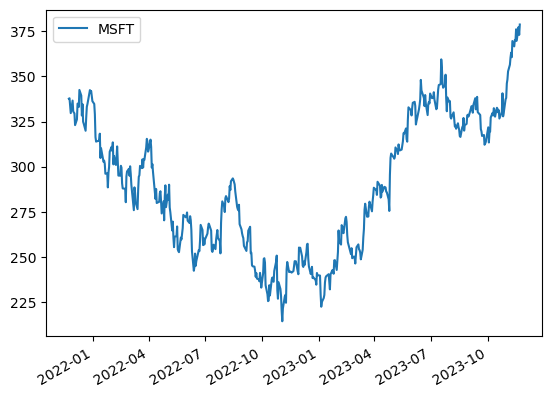

In [14]:
df.plot()

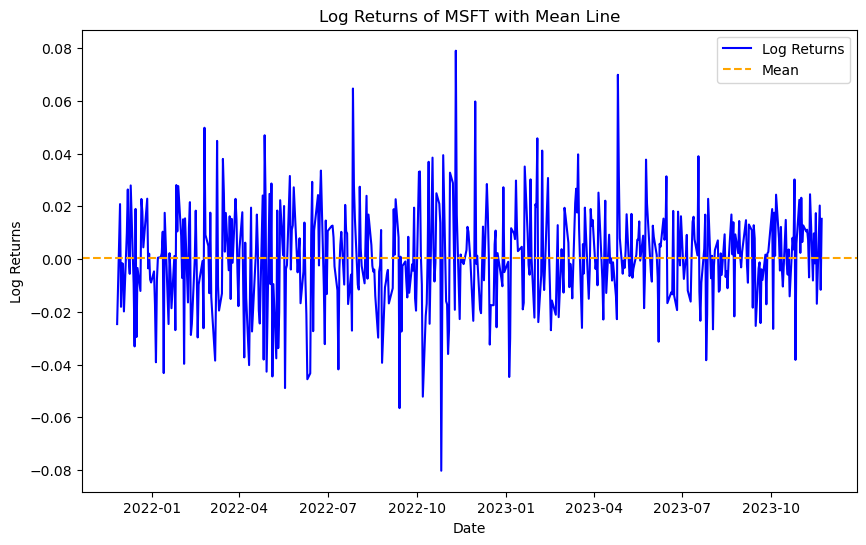

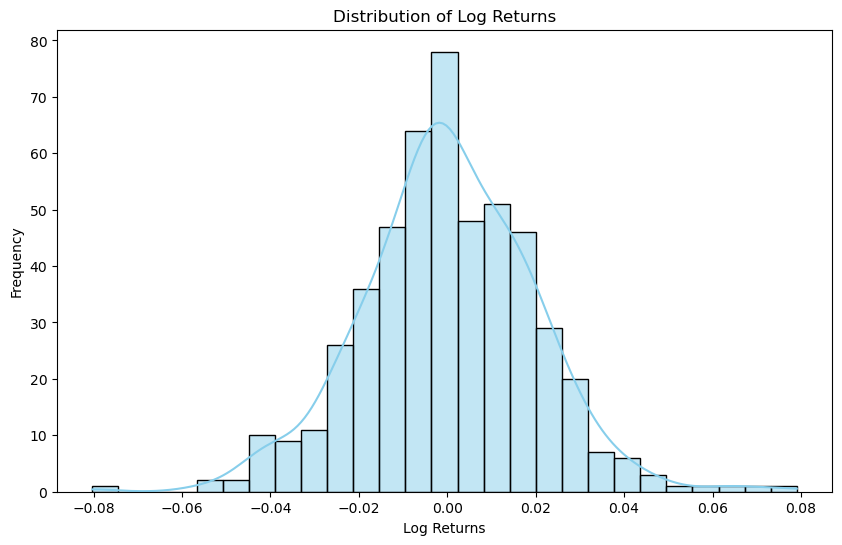

Descriptive Statistics for Log Returns:
                                                         0  additional_stats
nobs                                                  501               NaN
minmax        (-0.08029538884051364, 0.07905889269022823)               NaN
mean                                             0.000228               NaN
variance                                         0.000385               NaN
skewness                                         0.038981               NaN
kurtosis                                          1.12763               NaN
50% (median)                                          NaN         -0.000207
std                                                   NaN          0.019624
Jarque-Bera                                           NaN         26.670479
p-value                                               NaN          0.000002


In [24]:
from scipy.stats import describe, jarque_bera

# Calculate log returns
df["logret"] = np.log(df["MSFT"] / df["MSFT"].shift(1))

df.dropna(inplace=True)

# Plot log returns with mean line
plt.figure(figsize=(10, 6))
plt.plot(df.index, df["logret"], label="Log Returns", color="blue")
plt.axhline(y=df["logret"].mean(), color="orange", linestyle="--", label="Mean")
plt.title("Log Returns of MSFT with Mean Line")
plt.xlabel("Date")
plt.ylabel("Log Returns")
plt.legend()
plt.show()

# Descriptive statistics
statistics = describe(df["logret"])

# Create a DataFrame for additional statistics and concatenate with original statistics
additional_stats = pd.Series({
    '50% (median)': np.median(df["logret"]),
    'std': statistics.variance**0.5,
    'Jarque-Bera': jarque_bera(df["logret"])[0],
    'p-value': jarque_bera(df["logret"])[1]
}, name='additional_stats')

statistics = pd.concat([pd.Series(statistics._asdict()), additional_stats], axis=1)

# Distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(df["logret"].dropna(), kde=True, color="skyblue")
plt.title("Distribution of Log Returns")
plt.xlabel("Log Returns")
plt.ylabel("Frequency")
plt.show()

# Print descriptive statistics
print("Descriptive Statistics for Log Returns:\n", statistics)

[*********************100%%**********************]  1 of 1 completed
Iteration:      1,   Func. Count:      8,   Neg. LLF: 567022363.7892513
Iteration:      2,   Func. Count:     21,   Neg. LLF: 12171.55561096057
Iteration:      3,   Func. Count:     33,   Neg. LLF: 2697.7373952901908
Iteration:      4,   Func. Count:     45,   Neg. LLF: 2549.479190668362
Iteration:      5,   Func. Count:     57,   Neg. LLF: -1081.593968834747
Iteration:      6,   Func. Count:     65,   Neg. LLF: -1245.282804270411
Iteration:      7,   Func. Count:     74,   Neg. LLF: -1086.7545302640126
Iteration:      8,   Func. Count:     82,   Neg. LLF: -1271.0804058569806
Iteration:      9,   Func. Count:     89,   Neg. LLF: -1255.3621262864806
Iteration:     10,   Func. Count:    100,   Neg. LLF: -1270.864371825343
Iteration:     11,   Func. Count:    108,   Neg. LLF: -1271.2921745431322
Iteration:     12,   Func. Count:    115,   Neg. LLF: -1271.2871188177983
Iteration:     13,   Func. Count:    123,   Neg. LLF:

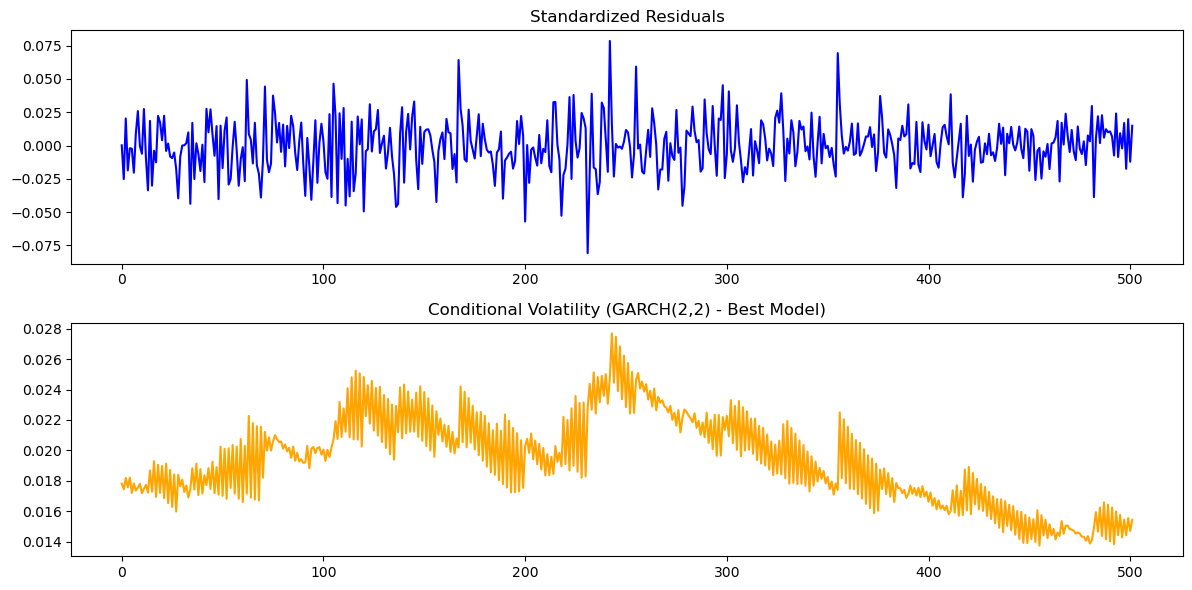

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from arch import arch_model

# Set the start and end dates
start_date = "2021-11-23"
end_date = "2023-11-23"

# Define the ticker symbol
ticker = "MSFT"

# Fetch stock data using yfinance
data = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Calculate log returns
data["logret"] = np.log(data["Close"] / data["Close"].shift(1))

# Remove missing values
data.dropna(inplace=True)

# Find the best p and q based on AIC and BIC
best_aic = float("inf")
best_bic = float("inf")
best_p = 0
best_q = 0

log_returns = data["logret"].to_numpy()

for p in range(1, 6):  # Try p from 1 to 5
    for q in range(1, 6):  # Try q from 1 to 5
        try:
            model = arch_model(log_returns, vol="Garch", p=p, q=q)
            results = model.fit(disp="off")  # Turn off display to suppress output
            aic = results.aic
            bic = results.bic

            if aic < best_aic:
                best_aic = aic
                best_p = p
                best_q = q

            if bic < best_bic:
                best_bic = bic
        except Exception as e:
            print(f"Issue with p={p}, q={q}: {e}")

# Fit the best model
best_model = arch_model(log_returns, vol="Garch", p=best_p, q=best_q)
best_results = best_model.fit()

# Display the best model summary
print("Best Model (p={}, q={}):".format(best_p, best_q))
print(best_results.summary())

# Plot the standardized residuals and conditional volatility for the best model
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(best_results.resid, color='blue')
plt.title('Standardized Residuals')

plt.subplot(2, 1, 2)
plt.plot(best_results.conditional_volatility, color='orange')
plt.title('Conditional Volatility (GARCH({},{}) - Best Model)'.format(best_p, best_q))

plt.tight_layout()
plt.show()


Iteration:      1,   Func. Count:      8,   Neg. LLF: 64805384027.46865
Iteration:      2,   Func. Count:     21,   Neg. LLF: 8737878246.192558
Iteration:      3,   Func. Count:     34,   Neg. LLF: 234900.16926321888
Iteration:      4,   Func. Count:     47,   Neg. LLF: 298.77323793036044
Iteration:      5,   Func. Count:     58,   Neg. LLF: 199599.19260888442
Iteration:      6,   Func. Count:     71,   Neg. LLF: -1072.9351585197192
Iteration:      7,   Func. Count:     79,   Neg. LLF: -985.6708035491877
Iteration:      8,   Func. Count:     87,   Neg. LLF: -1222.452281462866
Iteration:      9,   Func. Count:     95,   Neg. LLF: -1225.0845585127981
Iteration:     10,   Func. Count:    102,   Neg. LLF: -1204.527299194728
Iteration:     11,   Func. Count:    114,   Neg. LLF: -1223.616996488082
Iteration:     12,   Func. Count:    122,   Neg. LLF: -1225.755074995846
Iteration:     13,   Func. Count:    128,   Neg. LLF: -1225.7550741305834
Optimization terminated successfully    (Exit mode

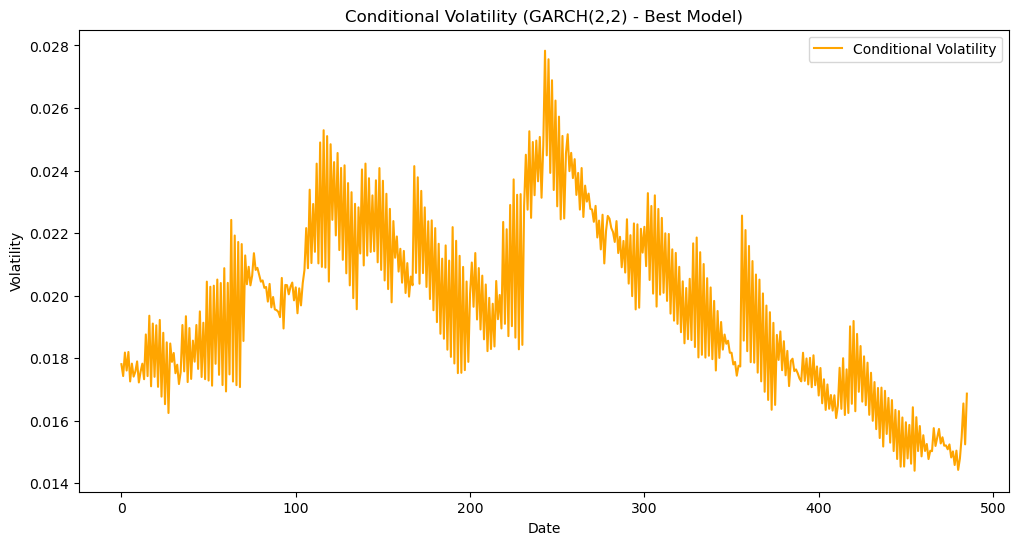

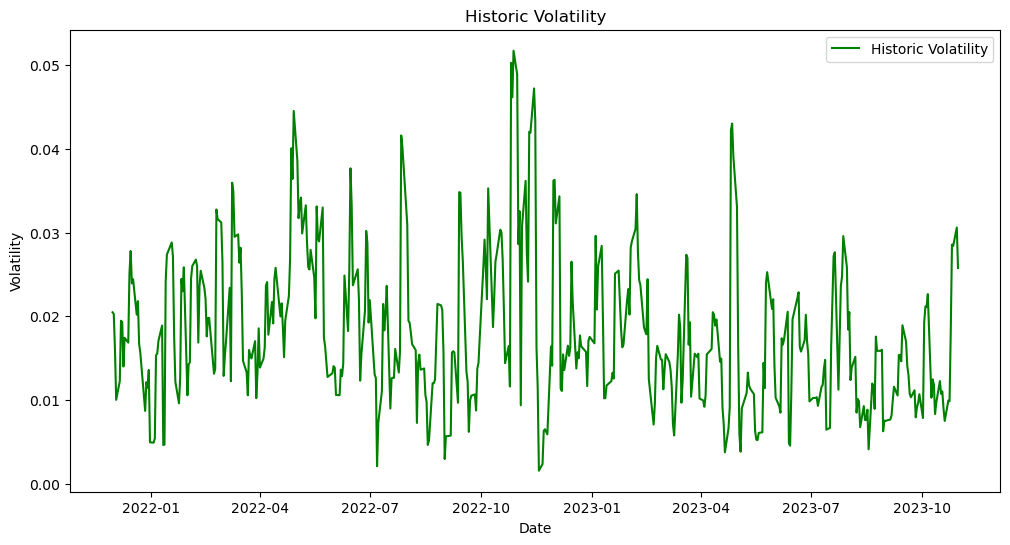

In [36]:
# Fit the best GARCH model
best_model = arch_model(data["logret"].to_numpy(), vol="Garch", p=best_p, q=best_q)
best_results = best_model.fit()

# Calculate historic volatility (rolling standard deviation)
data["historic_volatility"] = data["logret"].rolling(window=best_p + best_q).std()

# Plot conditional volatility
plt.figure(figsize=(12, 6))
plt.plot(best_results.conditional_volatility, color='orange', label='Conditional Volatility')
plt.title('Conditional Volatility (GARCH({},{}) - Best Model)'.format(2, 2))
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# Plot historic volatility
plt.figure(figsize=(12, 6))
plt.plot(data["historic_volatility"], color='green', label='Historic Volatility')
plt.title('Historic Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

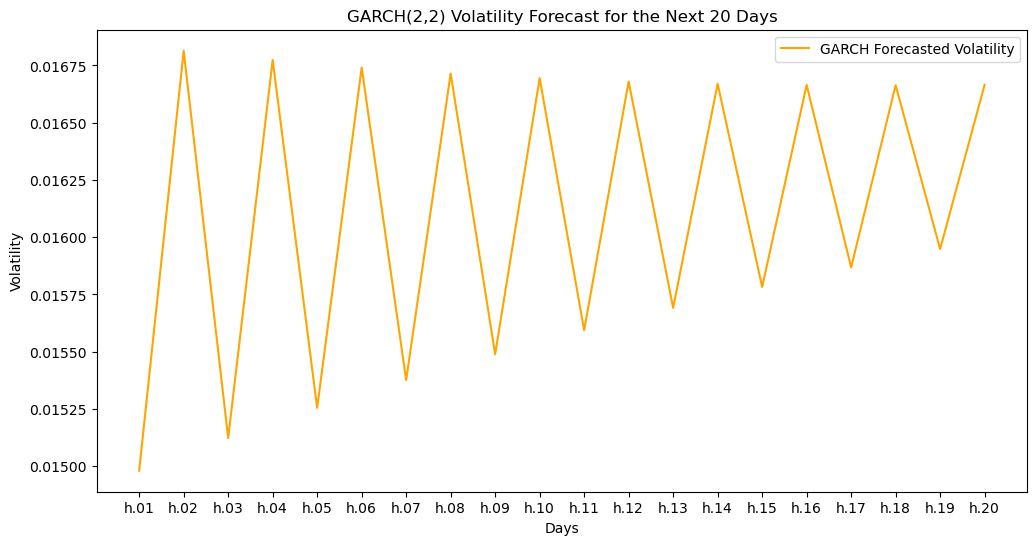

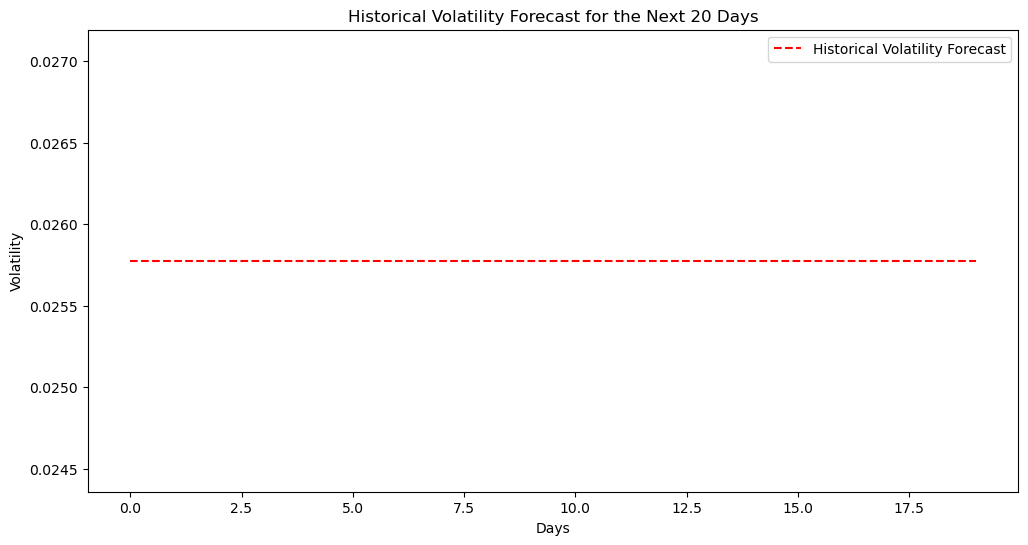

In [41]:
# Forecast volatility for the next 20 days using the best GARCH model
forecast_horizon = 20
forecasts = best_results.forecast(start=None, horizon=forecast_horizon)

# Extract forecasted volatility
garch_forecasted_volatility = np.sqrt(forecasts.variance.iloc[-1, :])

# Plot GARCH forecasted volatility for the next 20 days
plt.figure(figsize=(12, 6))
plt.plot(garch_forecasted_volatility, color='orange', label='GARCH Forecasted Volatility')
plt.title('GARCH(2,2) Volatility Forecast for the Next 20 Days')
plt.xlabel('Days')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# Forecast volatility for the next 20 days using historical volatility
historical_volatility_forecast = data["historic_volatility"].iloc[-1]  # Assuming last observed historical volatility continues
historical_volatility_forecast = np.full(20, historical_volatility_forecast)

# Plot historical volatility forecast for the next 20 days
plt.figure(figsize=(12, 6))
plt.plot(historical_volatility_forecast, color='red', linestyle='--', label='Historical Volatility Forecast')
plt.title('Historical Volatility Forecast for the Next 20 Days')
plt.xlabel('Days')
plt.ylabel('Volatility')
plt.legend()
plt.show()


In [38]:
# Forecast volatility for the next 20 days using historical volatility
historical_volatility_forecast = data["historic_volatility"].iloc[-1]  # Assuming last observed historical volatility continues
historical_volatility_forecast = np.full(20, historical_volatility_forecast)

# Print out the historical volatility forecast value for the next 20 days
print("Historical Volatility Forecast for the Next 20 Days:", historical_volatility_forecast)

Historical Volatility Forecast for the Next 20 Days: [0.02577516 0.02577516 0.02577516 0.02577516 0.02577516 0.02577516
 0.02577516 0.02577516 0.02577516 0.02577516 0.02577516 0.02577516
 0.02577516 0.02577516 0.02577516 0.02577516 0.02577516 0.02577516
 0.02577516 0.02577516]


Iteration:      1,   Func. Count:      8,   Neg. LLF: 569203055.7998729
Iteration:      2,   Func. Count:     21,   Neg. LLF: 104560235.14845923
Iteration:      3,   Func. Count:     34,   Neg. LLF: 25437.045682382104
Iteration:      4,   Func. Count:     46,   Neg. LLF: 333969.57156670827
Iteration:      5,   Func. Count:     59,   Neg. LLF: 264.4948934547879
Iteration:      6,   Func. Count:     70,   Neg. LLF: 3218.2253945653215
Iteration:      7,   Func. Count:     82,   Neg. LLF: 13700.53264803112
Iteration:      8,   Func. Count:     94,   Neg. LLF: -1063.5729386323176
Iteration:      9,   Func. Count:    102,   Neg. LLF: -1163.9372809017361
Iteration:     10,   Func. Count:    111,   Neg. LLF: -1271.3545325503035
Iteration:     11,   Func. Count:    118,   Neg. LLF: -1257.3770448620999
Iteration:     12,   Func. Count:    129,   Neg. LLF: -1271.452341144442
Iteration:     13,   Func. Count:    136,   Neg. LLF: -1271.4560159248094
Iteration:     14,   Func. Count:    144,   Neg. 

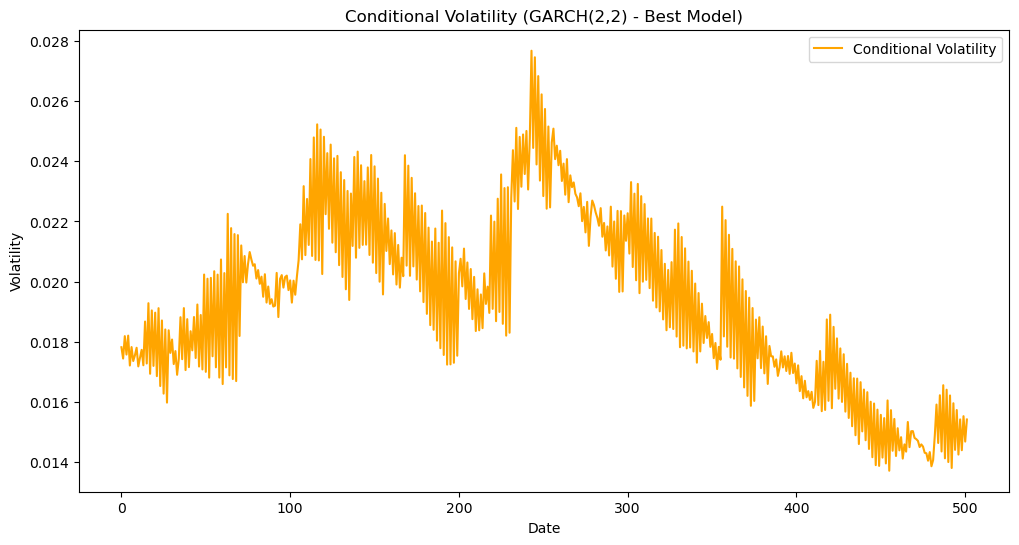

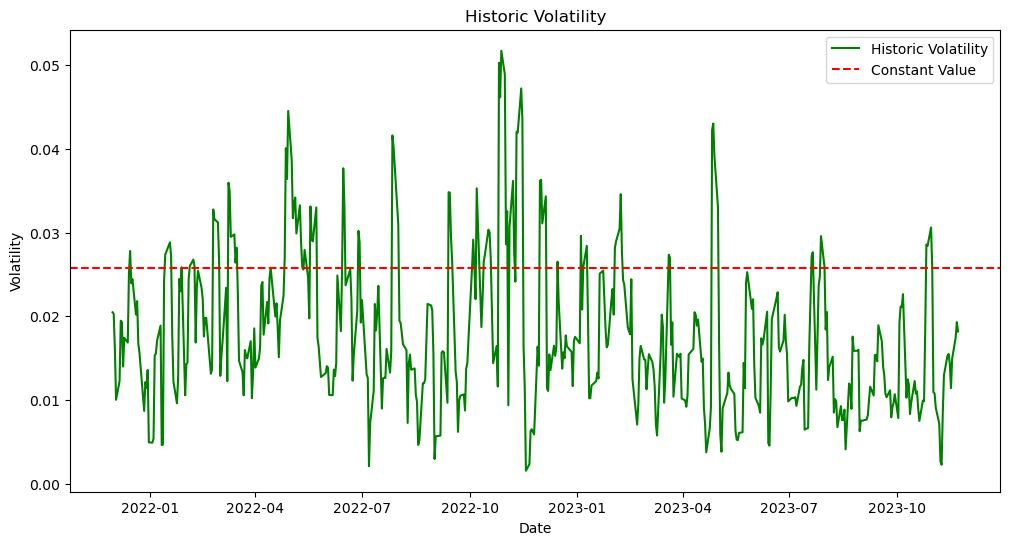

In [69]:
# Fit the best GARCH model
best_model = arch_model(data["logret"].to_numpy(), vol="Garch", p=best_p, q=best_q)
best_results = best_model.fit()

# Calculate historic volatility (rolling standard deviation)
data["historic_volatility"] = data["logret"].rolling(window=best_p + best_q).std()

# Plot conditional volatility
plt.figure(figsize=(12, 6))
plt.plot(best_results.conditional_volatility, color='orange', label='Conditional Volatility')
plt.title('Conditional Volatility (GARCH({},{}) - Best Model)'.format(2, 2))
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# Plot historic volatility
plt.figure(figsize=(12, 6))
plt.plot(data["historic_volatility"], color='green', label='Historic Volatility')
plt.axhline(y=0.02577516, color='red', linestyle='--', label='Constant Value')
plt.title('Historic Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

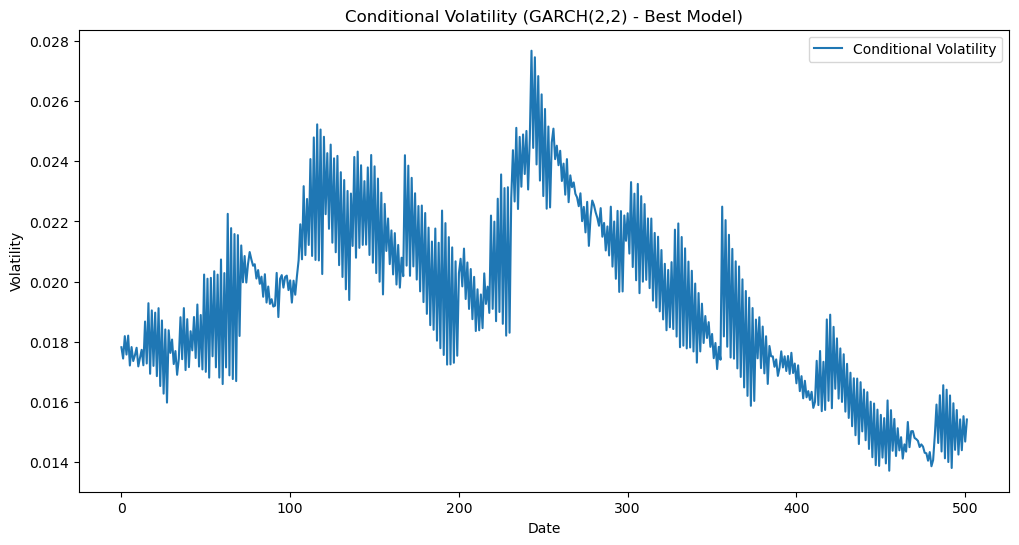

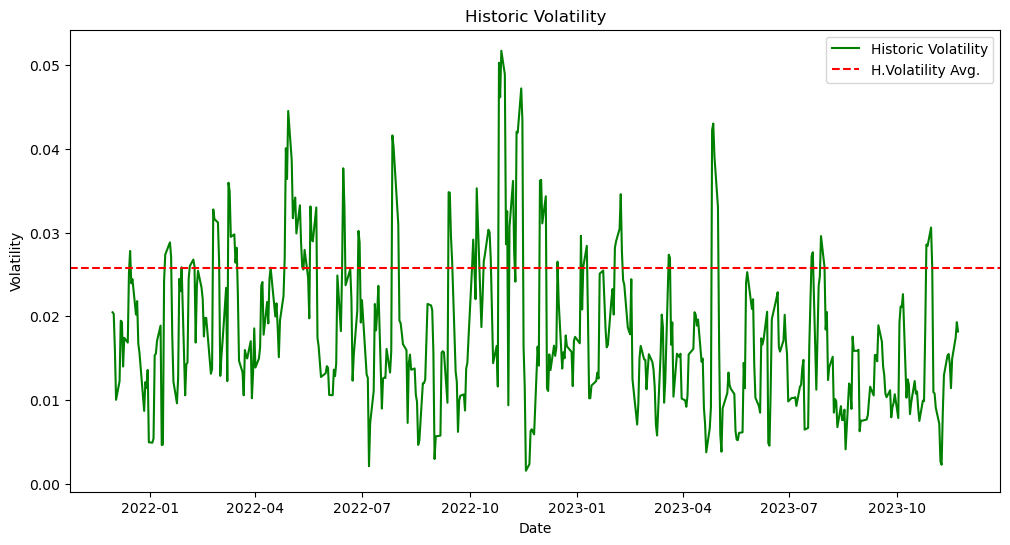

In [73]:
# Plot conditional volatility
plt.figure(figsize=(12, 6))
plt.plot(best_results.conditional_volatility, label='Conditional Volatility')
plt.title('Conditional Volatility (GARCH({},{}) - Best Model)'.format(2, 2))
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# Plot historic volatility
plt.figure(figsize=(12, 6))
plt.plot(data["historic_volatility"], color='green', label='Historic Volatility')
plt.axhline(y=0.02577516, color='red', linestyle='--', label='H.Volatility Avg.')
plt.title('Historic Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

[*********************100%%**********************]  1 of 1 completed


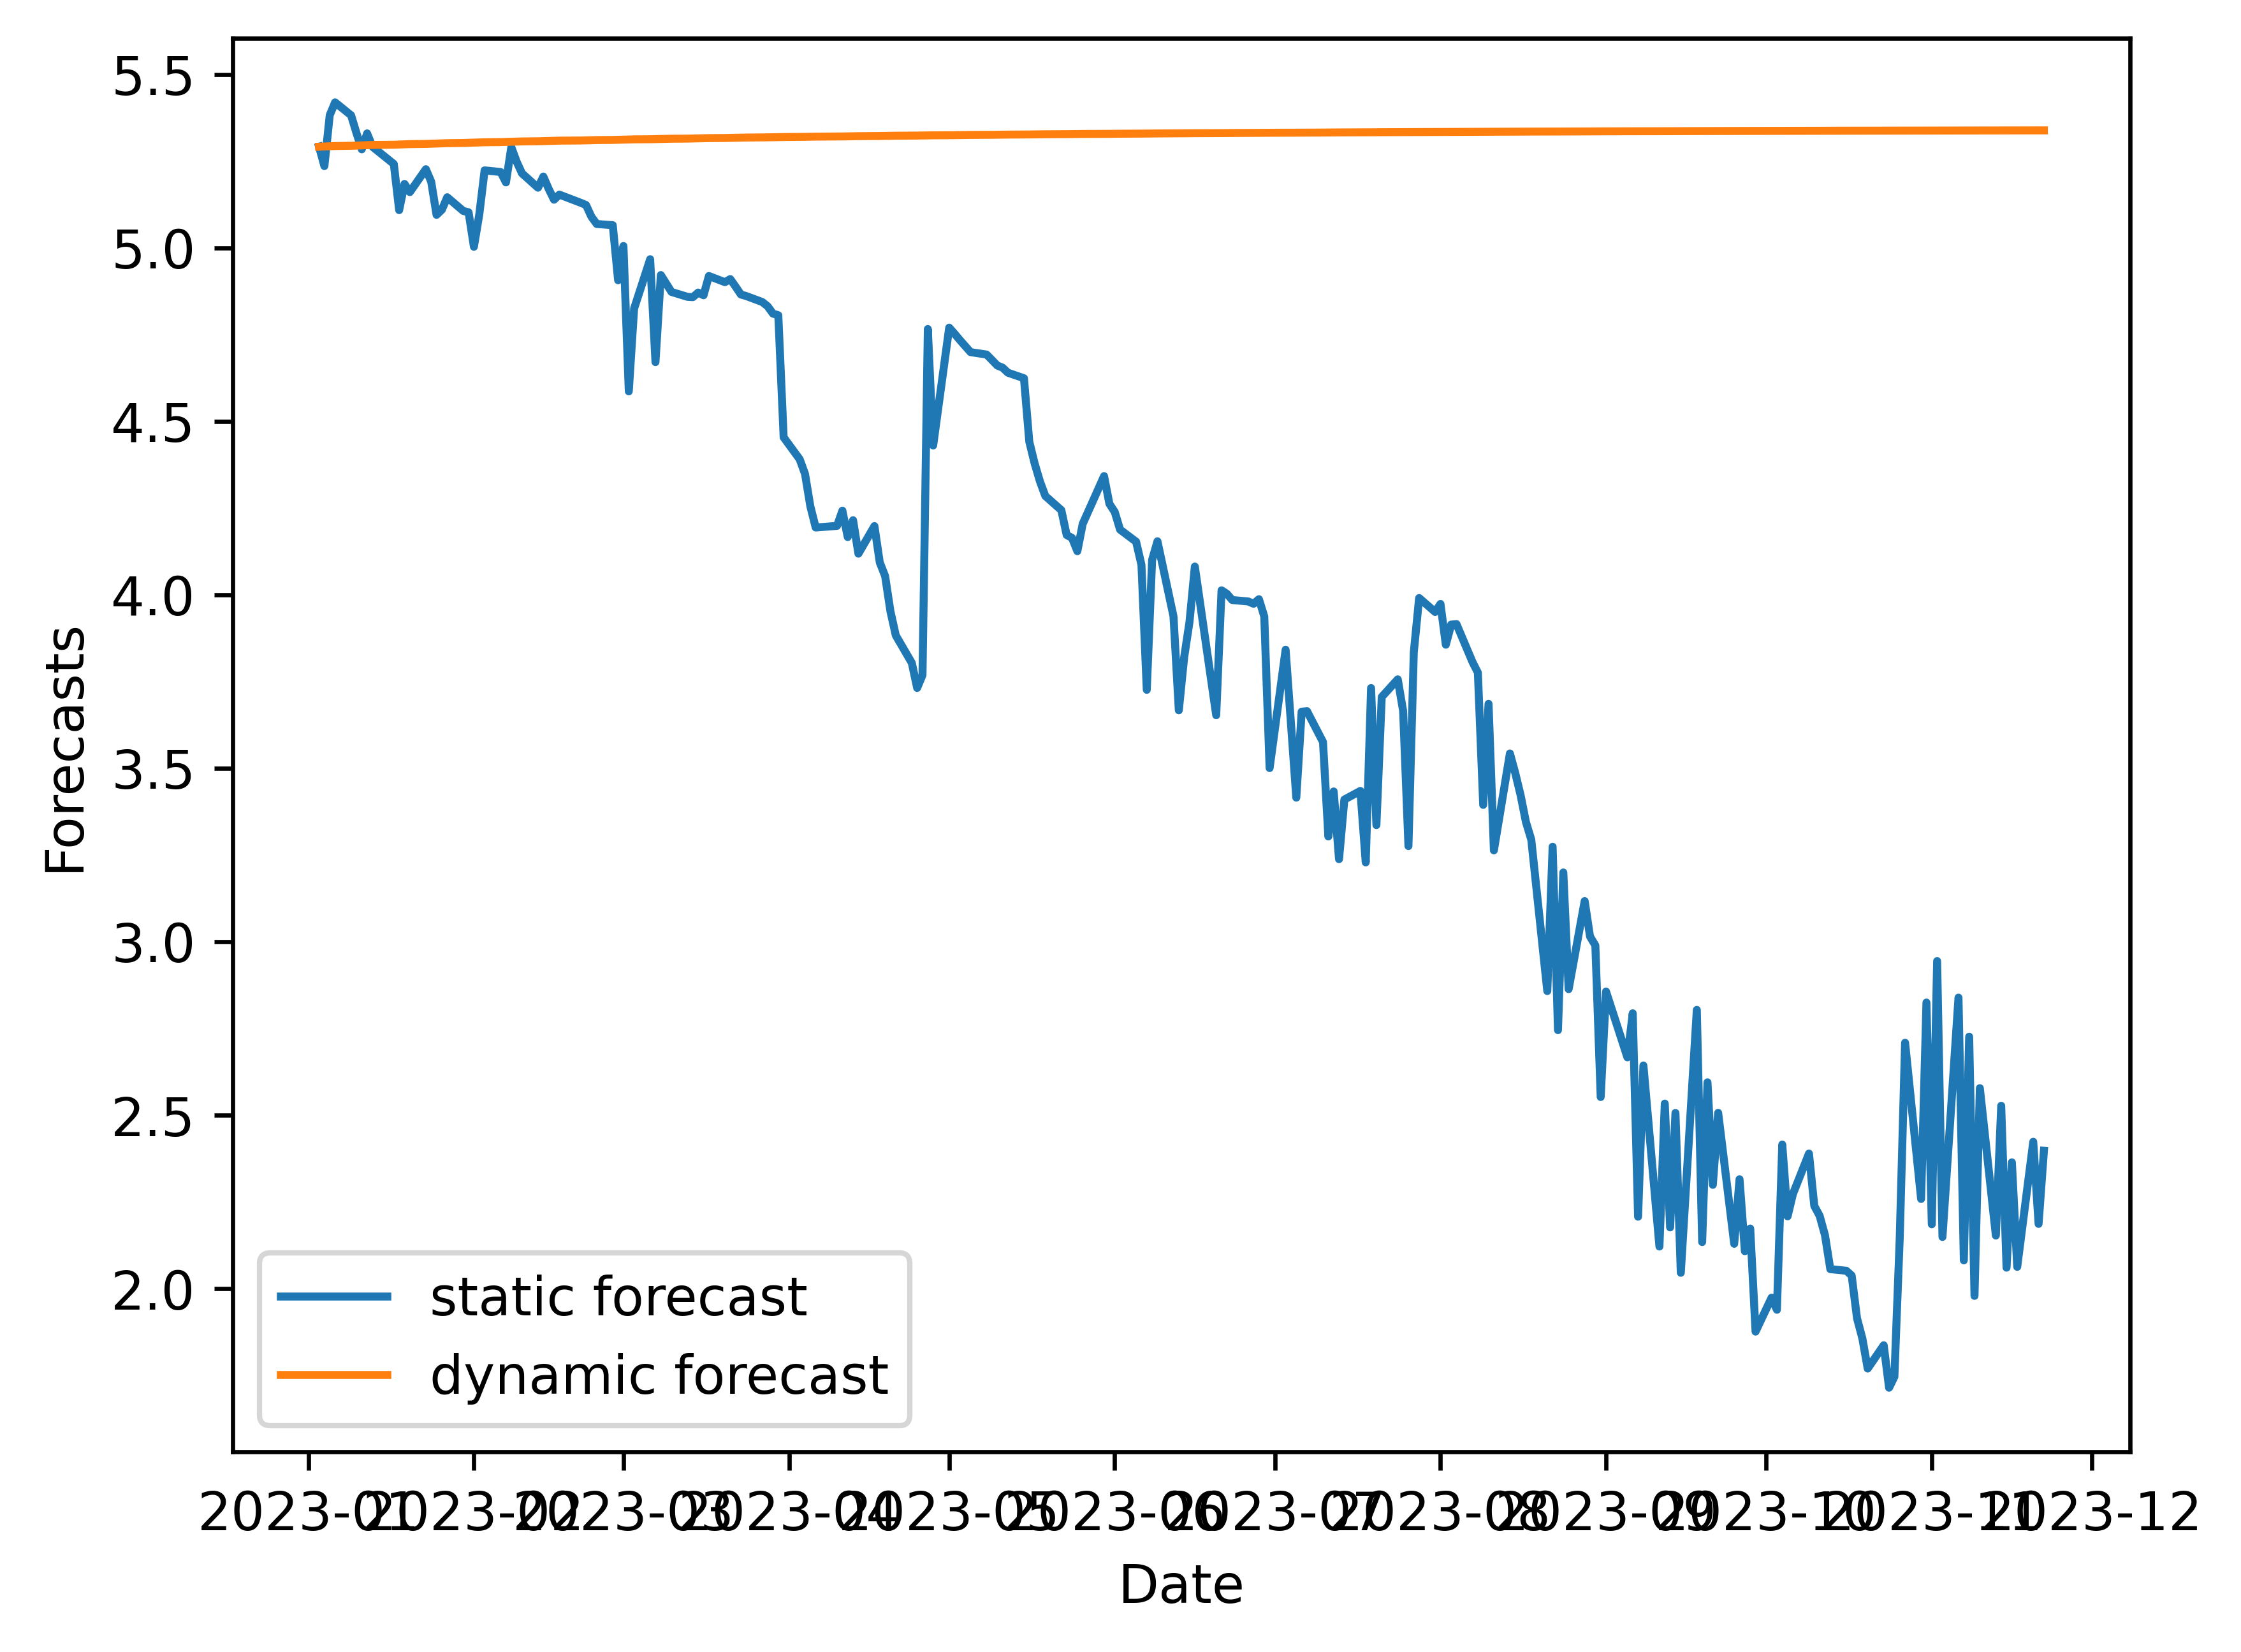

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from arch import arch_model

# Set the start and end dates
start_date = "2021-11-23"
end_date = "2023-11-23"

# Define the ticker symbol
ticker = "MSFT"

# Fetch stock data using yfinance
data = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Calculate log returns
data["logret"] = np.log(data["Close"] / data["Close"].shift(1))

# Remove missing values
data.dropna(inplace=True)

# Sampling
data_in_the_sample = data["logret"].loc[:'2022-12-31']
data_out_of_the_sample = data["logret"].loc['2023-01-01':]

# Fit the GARCH model to the entire dataset (in-sample and out-of-sample)
am = arch_model(data["logret"], vol='Garch', p=2, q=2, rescale=True)

# Static Forecast
cvar_rjpy_stat = {}
for date in data_out_of_the_sample.index:
    res = am.fit(last_obs=date, disp='off')
    forecasts = res.forecast(horizon=1)
    forecasts_res = forecasts.variance.dropna()
    cvar_rjpy_stat[date] = forecasts_res.iloc[0]
                                     
cvar_rjpy_stat = pd.DataFrame(cvar_rjpy_stat).T

# Dynamic Forecast
res = am.fit(last_obs='2023-01-01', disp='off')
forecasts = res.forecast(horizon=len(data_out_of_the_sample))
forecasts_res = forecasts.variance.dropna()

# Exclude the last element to match the index length
cvar_rjpy_dyn = pd.DataFrame(
    data=forecasts_res.iloc[:-1, 0].values,
    columns=['dynamic forecasting'],
    index=data_out_of_the_sample.index
)

# Plot
plt.figure(1, dpi=600)
plt.plot(cvar_rjpy_stat, label='static forecast')
plt.plot(cvar_rjpy_dyn, label='dynamic forecast')
plt.xlabel('Date')
plt.ylabel('Forecasts')
plt.legend()
plt.show()

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from arch import arch_model

# Set the start and end dates
start_date = "2021-11-23"
end_date = "2023-11-23"

# Define the ticker symbol
ticker = "MSFT"

# Fetch stock data using yfinance
data = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Calculate log returns
data["logret"] = np.log(data["Close"] / data["Close"].shift(1))

# Remove missing values
data.dropna(inplace=True)

# Split the data into in-sample and out-of-sample
in_sample_data = data.loc[:'2023-10-31']
out_of_sample_data = data.loc['2023-11-01':'2023-11-21']

# Fit the GARCH model to the entire dataset (in-sample and out-of-sample)
am = arch_model(in_sample_data["logret"], vol='Garch', p=2, q=2, rescale=True)

# Static Forecast
cvar_rjpy_stat = {}
for date in out_of_sample_data.index:
    res = am.fit(last_obs=date, disp='off')
    forecasts = res.forecast(horizon=1)
    forecasts_res = forecasts.variance.dropna()
    cvar_rjpy_stat[date] = forecasts_res.iloc[0]

cvar_rjpy_stat = pd.DataFrame(cvar_rjpy_stat).T

# Dynamic Forecast
res = am.fit(last_obs='2023-11-01', disp='off')
forecasts = res.forecast(horizon=len(out_of_sample_data))
forecasts_res = forecasts.variance.dropna()

# Include all elements and match the index length
cvar_rjpy_dyn = pd.DataFrame(
    data=forecasts_res.values[:-1, 0],
    columns=['dynamic forecasting'],
    index=out_of_sample_data.index[:-1]
)

# Plot
plt.figure(1, dpi=600)
plt.plot(cvar_rjpy_stat, label='static forecast')
plt.plot(cvar_rjpy_dyn, label='dynamic forecast')
plt.xlabel('Date')
plt.ylabel('Forecasts')
plt.legend()
plt.show()


[*********************100%%**********************]  1 of 1 completed


ValueError: Empty data passed with indices specified.

[*********************100%%**********************]  1 of 1 completed
Iteration:      1,   Func. Count:      8,   Neg. LLF: 64805384027.46865
Iteration:      2,   Func. Count:     21,   Neg. LLF: 8737878246.192558
Iteration:      3,   Func. Count:     34,   Neg. LLF: 234900.16926321888
Iteration:      4,   Func. Count:     47,   Neg. LLF: 298.77323793036044
Iteration:      5,   Func. Count:     58,   Neg. LLF: 199599.19260888442
Iteration:      6,   Func. Count:     71,   Neg. LLF: -1072.9351585197192
Iteration:      7,   Func. Count:     79,   Neg. LLF: -985.6708035491877
Iteration:      8,   Func. Count:     87,   Neg. LLF: -1222.452281462866
Iteration:      9,   Func. Count:     95,   Neg. LLF: -1225.0845585127981
Iteration:     10,   Func. Count:    102,   Neg. LLF: -1204.527299194728
Iteration:     11,   Func. Count:    114,   Neg. LLF: -1223.616996488082
Iteration:     12,   Func. Count:    122,   Neg. LLF: -1225.755074995846
Iteration:     13,   Func. Count:    128,   Neg. LLF: -

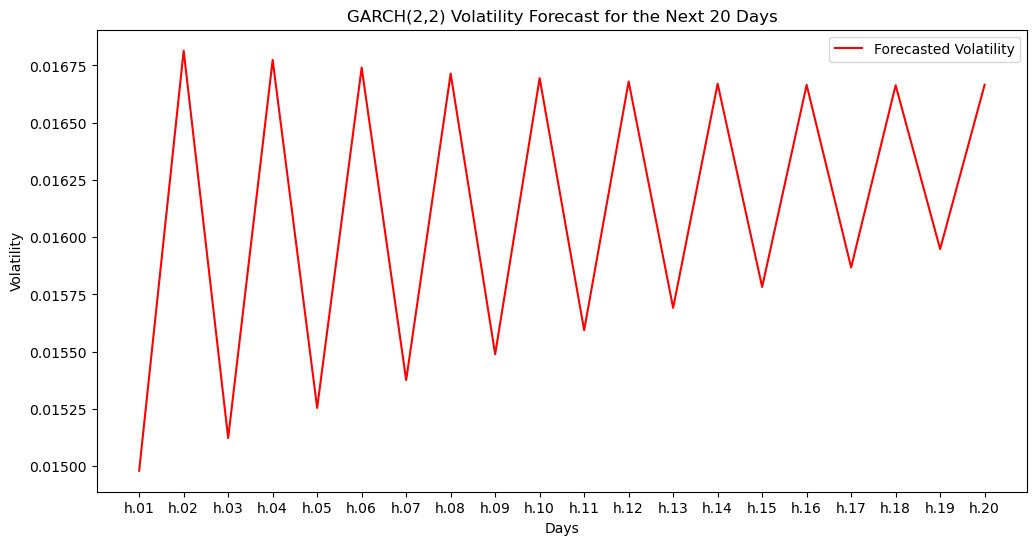

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from arch import arch_model

# Set the start and end dates
start_date = "2021-11-23"
end_date = "2023-11-01"

# Define the ticker symbol
ticker = "MSFT"

# Fetch stock data using yfinance
data = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Calculate log returns
data["logret"] = np.log(data["Close"] / data["Close"].shift(1))

# Remove missing values
data.dropna(inplace=True)

# Fit GARCH(2,2) model
garch_model = arch_model(data["logret"], vol="Garch", p=2, q=2)
garch_results = garch_model.fit()

# Forecast volatility for the next 20 days
forecast_horizon = 20
forecasts = garch_results.forecast(start=None, horizon=forecast_horizon)

# Extract forecasted volatility
forecasted_volatility = np.sqrt(forecasts.variance.iloc[-1, :])

# Plot forecasted volatility for the next 20 days
plt.figure(figsize=(12, 6))
plt.plot(forecasted_volatility, color='red', label='Forecasted Volatility')
plt.title('GARCH(2,2) Volatility Forecast for the Next 20 Days')
plt.xlabel('Days')
plt.ylabel('Volatility')
plt.legend()
plt.show()


[*********************100%%**********************]  1 of 1 completed


/Users/khizarbilal/anaconda3/lib/python3.10/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/khizarbilal/anaconda3/lib/python3.10/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/khizarbilal/anaconda3/lib/python3.10/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/khizarbilal/anaconda3/lib/python3.10/site-packages/arch/univariate/base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearc

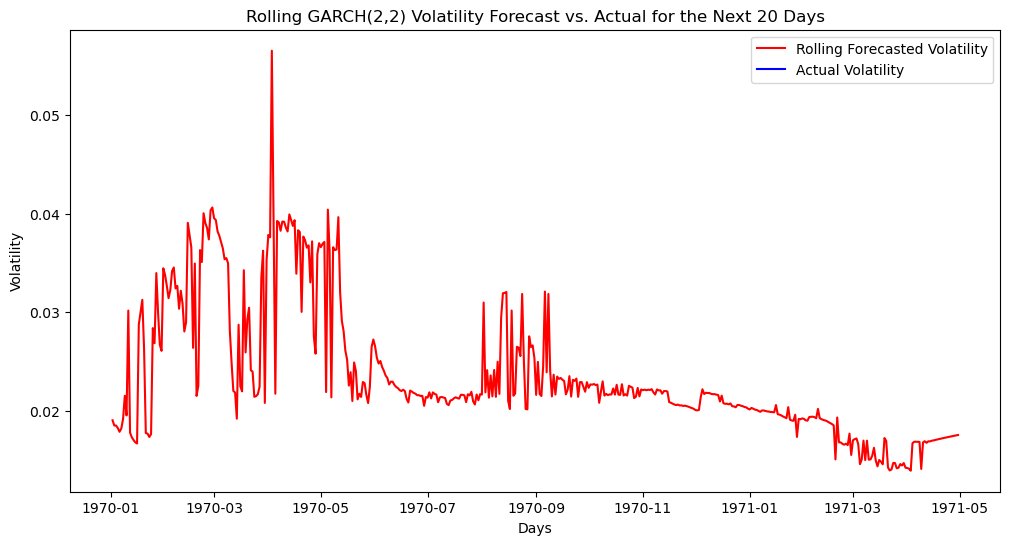

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from arch import arch_model

# Set the start and end dates
start_date = "2021-11-23"
end_date = "2023-11-01"

# Define the ticker symbol
ticker = "MSFT"

# Fetch stock data using yfinance
data = yf.download(ticker, start=start_date, end=end_date, interval="1d")

# Calculate log returns
data["logret"] = np.log(data["Close"] / data["Close"].shift(1))

# Remove missing values
data.dropna(inplace=True)

# Initialize arrays to store forecasted volatility
rolling_forecasted_volatility = np.full(len(data), np.nan)

# Specify GARCH(2,2) model
garch_model = arch_model(data["logret"], vol="Garch", p=2, q=2)

# Rolling forecast for the next 20 days
for i in range(len(data)):
    if i + 21 < len(data):
        # Fit GARCH model with data up to the current day
        garch_results = garch_model.fit(first_obs=0, last_obs=i + 20, disp="off")

        # Forecast volatility for the next 20 days
        forecasts = garch_results.forecast(start=i + 1, horizon=20)
        forecasted_volatility = np.sqrt(forecasts.variance.iloc[-1, :])

        # Store the 1-day ahead forecasted volatility
        rolling_forecasted_volatility[i + 1:i + 21] = forecasted_volatility

# Plot rolling forecasted and actual volatility for the next 20 days
plt.figure(figsize=(12, 6))
plt.plot(rolling_forecasted_volatility, color='red', label='Rolling Forecasted Volatility')
plt.plot(actual_volatility, color='blue', label='Actual Volatility')
plt.title('Rolling GARCH(2,2) Volatility Forecast vs. Actual for the Next 20 Days')
plt.xlabel('Days')
plt.ylabel('Volatility')
plt.legend()
plt.show()


In [80]:
from scipy.stats import norm
from scipy.optimize import newton

def black_scholes_volatility(option_price, stock_price, strike_price, time_to_maturity, risk_free_rate, option_type='call'):
    """
    Calculate the implied volatility using the Black-Scholes model.

    Parameters:
    - option_price: Current option price
    - stock_price: Current stock price
    - strike_price: Option strike price
    - time_to_maturity: Time to option maturity (in years)
    - risk_free_rate: Risk-free interest rate (annualized)
    - option_type: 'call' for call option, 'put' for put option

    Returns:
    - Implied volatility
    """
    # Define the Black-Scholes equation
    def black_scholes_eq(volatility):
        d1 = (np.log(stock_price / strike_price) + (risk_free_rate + 0.5 * volatility**2) * time_to_maturity) / (volatility * np.sqrt(time_to_maturity))

        if option_type == 'call':
            option_price_calc = stock_price * norm.cdf(d1) - strike_price * np.exp(-risk_free_rate * time_to_maturity) * norm.cdf(d1 - volatility * np.sqrt(time_to_maturity))
        elif option_type == 'put':
            option_price_calc = strike_price * np.exp(-risk_free_rate * time_to_maturity) * norm.cdf(-d1 + volatility * np.sqrt(time_to_maturity)) - stock_price * norm.cdf(-d1)

        return option_price_calc - option_price

    
    return implied_volatility

# Example usage
option_price = 380.0  # Replace with the actual option price
stock_price = 377.0
strike_price = 377.0
time_to_maturity = 0.25  # 3 months to maturity
risk_free_rate = 0.05  # 2% risk-free rate
implied_volatility = black_scholes_volatility(option_price, stock_price, strike_price, time_to_maturity, risk_free_rate, option_type='call')
print("Implied Volatility:", implied_volatility)

Implied Volatility: 0.4364813821997387
